In [1]:
import uproot
import ROOT
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

Welcome to JupyROOT 6.14/02


In [7]:

def extract_teffi(eff):
    _ = ROOT.TCanvas()
    eff.Draw()
    ROOT.gPad.Update()
    
    tot = eff.GetTotalHistogram()
    nBins = tot.GetNbinsX()
    xx = np.array([tot.GetXaxis().GetBinCenter(i)                 for i in range(1, nBins+1)])
    yy = np.array([eff.GetEfficiency(eff.GetGlobalBin(i))         for i in range(1, nBins+1)])
    yl = np.array([eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)) for i in range(1, nBins+1)])
    yu = np.array([eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i))  for i in range(1, nBins+1)])
    
    return {'x': xx,
            'y': yy,
            'yerr': np.array([yu, yl])}

In [2]:
from collections import OrderedDict

trees = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03_100k.root')['TRIG_dsa/trigEffiForMuTrack'],
      1 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012_100k.root'   )['TRIG_dsa/trigEffiForMuTrack'],
     10 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12_100k.root'    )['TRIG_dsa/trigEffiForMuTrack'],
     50 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6_100k.root'     )['TRIG_dsa/trigEffiForMuTrack'],
    100 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2_100k.root'     )['TRIG_dsa/trigEffiForMuTrack'],
    300 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6_100k.root'     )['TRIG_dsa/trigEffiForMuTrack']     
})

In [4]:
trees[1].keys()

[b'fired', b'pt', b'eta', b'phi']

In [5]:
import pandas as pd
_dict = {}
for k, t in trees.items():
    _counts = t.pandas.df(['fired'])[b'fired'].value_counts()
    _counts /= _counts.sum()
    _dict[k] = _counts
pd.DataFrame(_dict) 

,0.1,1.0,10.0,50.0,100.0,300.0
False,0.071789,0.079311,0.593969,0.95466,0.984218,0.994578
True,0.928211,0.920689,0.406031,0.04534,0.015782,0.005422


Text(0.5,0,'$p_{T}$ [GeV]')

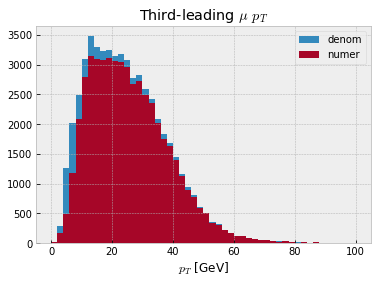

In [6]:
t = trees[1]
pt = t.array('pt')
start = pt.starts
denom = pt.content[start+2]
fd = t.array('fired')
numer = pt.content[start[fd]+2]
fig,ax = plt.subplots()
ax.hist(denom, bins=50, range=(0,100), label='denom')
ax.hist(numer, bins=50, range=(0,100), label='numer')
ax.legend(loc='best')
ax.set_title('Third-leading $\mu$ $p_{T}$')
ax.set_xlabel('$p_{T}$ [GeV]')

### Trigger `HLT_TrkMu16_DoubleTrkMu6NoFiltersNoVtx_v10` Efficiency as a function of third leading $\mu$ $p_{T}$

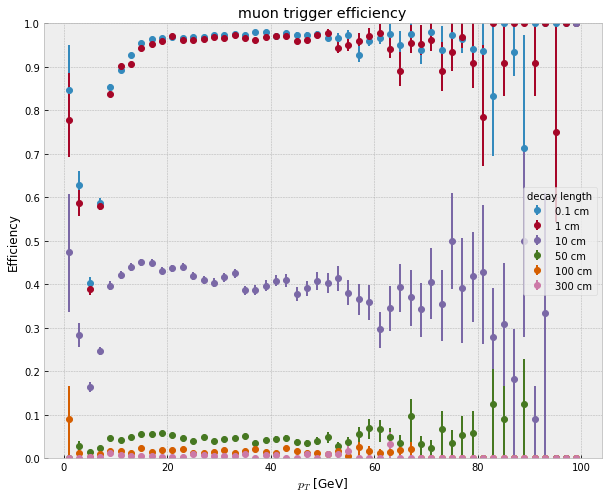

In [8]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in trees.items():
    d = t.array('pt')
    start = d.starts
    denom = d.content[start+2]
    fd = t.array('fired')
    numer = d.content[start[fd]+2]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, 0, 100)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, 0, 100)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

### Trigger `HLT_TrkMu16_DoubleTrkMu6NoFiltersNoVtx_v10` Efficiency as a function of third leading $\mu$ $\eta$

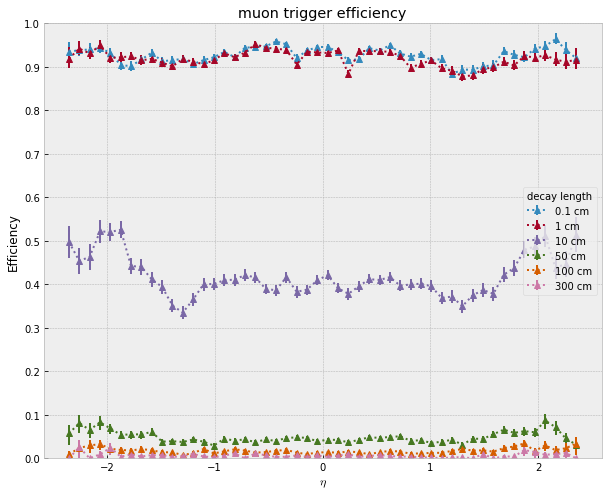

In [9]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in trees.items():
    d = t.array('eta')
    start = d.starts
    denom = d.content[start+2]
    fd = t.array('fired')
    numer = d.content[start[fd]+2]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, -2.4, 2.4)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, -2.4, 2.4)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

### trigger efficiency itself

In [10]:
trees = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03_100k.root')['TRIGself_dsa/trigSelfEffiForMuTrack'],
      1 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012_100k.root'   )['TRIGself_dsa/trigSelfEffiForMuTrack'],
     10 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12_100k.root'    )['TRIGself_dsa/trigSelfEffiForMuTrack'],
     50 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6_100k.root'     )['TRIGself_dsa/trigSelfEffiForMuTrack'],
    100 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2_100k.root'     )['TRIGself_dsa/trigSelfEffiForMuTrack'],
    300 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6_100k.root'     )['TRIGself_dsa/trigSelfEffiForMuTrack']     
})

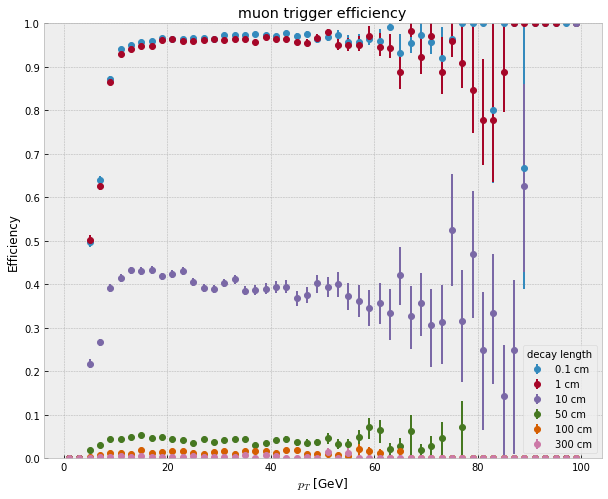

In [11]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in trees.items():
    d = t.array('pt')
    start = d.starts
    denom = d.content[start+2]
    fd = t.array('fired')
    numer = d.content[start[fd]+2]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, 0, 100)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, 0, 100)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

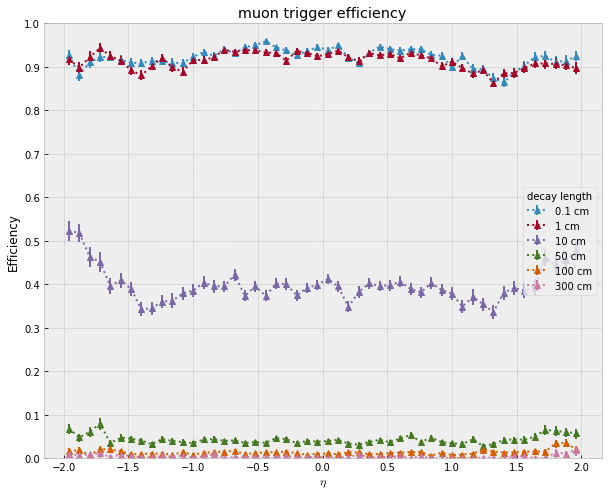

In [13]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in trees.items():
    d = t.array('eta')
    start = d.starts
    denom = d.content[start+2]
    fd = t.array('fired')
    numer = d.content[start[fd]+2]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, -2.0, 2.0)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, -2.0, 2.0)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

### Trigger efficiency as a function of dark photon's decay length

(0, 1)

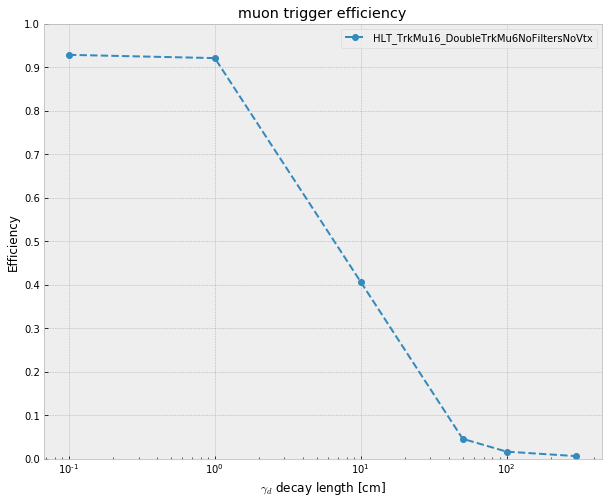

In [4]:
dl = np.array([0.1, 1.0, 10., 50., 100., 300.])
eff = {
    'HLT_TrkMu16_DoubleTrkMu6NoFiltersNoVtx': np.array([0.928211, 0.920689, 0.406031, 0.04534, 0.015782, 0.005422])
}

fig, ax = plt.subplots(figsize=(10,8))

for l, v in eff.items():
    ax.semilogx(dl, v, 'o--', label=l)
ax.legend(loc='best')
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$\gamma_{d}$ decay length [cm]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))